## Setup

In [1]:
dir = dirname(pwd()) * "/PROJECT"
include(dir * "/functions/Preamble.jl")
@everywhere dir = dirname(pwd()) * "/PROJECT"

t0 = now()

  Activating project at `C:\Users\conno\Documents\CAMBRIDGE\Part III\Comp Project\JULIA\PROJECT`

Num threads: 

6



2023-11-14T16:54:14.181

In [2]:
@everywhere include(dir * "/functions/CellComplex.jl")
@everywhere include(dir * "/functions/DataStructure.jl")
@everywhere include(dir * "/functions/Bases.jl")
@everywhere include(dir * "/functions/Plotting.jl")
@everywhere include(dir * "/functions/Statistics.jl")
@everywhere include(dir * "/functions/Simulation.jl")
@everywhere include(dir * "/functions/SingleVertexApproxns.jl")

@everywhere include(dir * "/functions/simulationFunctions/GroundStates.jl")

## GLOBAL INPUTS

### Energy Scales

In [3]:
# Hamiltonian constants
@everywhere global const λ::Float64 = 0
@everywhere global const ξ::Float64 = 1

# which dynamics to use (only affects microcanonical functions)
@everywhere global const twoFlip::Bool = false

# demon quantisation
@assert (λ==1 && ξ==0) || (λ==0 && ξ==1) # otherwise demons will break b/c not quantised
@everywhere global isSpinIce = (λ==0 && ξ==1)
@everywhere global const δE::Int = (λ==0) ? 8*ξ : 4*λ

### Lattice

In [4]:
# chosen basis
@everywhere Basis = SquareBasis() # DiamondBasis() # CubicBasis(2) # 

# coordination number of lattice (ASSERTED CONSTANT FOR OUR PURPOSES)
@everywhere z = Coordination(Basis)

# function to generate groundstate
@everywhere isDiamond = (z==4 && length(Basis[4])==3) # certainly not general, but avoids human error in me setting the ground state explicitly...
@everywhere GroundState!(field, cells) = GroundState!(field, cells, isDiamond)

In [5]:
# Approxn of self-diffusion coeff at zero density

@everywhere q = (mod(z,2)==0) ? 2 : 3 # minimal excitation charge |Q|
@everywhere na = (q + z) / 2 # number of allowed directions which don't increase |Q| on site

@everywhere global Dself = ((!isSpinIce || na==z) ? z : na*(1-2/na^2)) / 2 / length(Basis[4])

### Approxns

In [6]:
if twoFlip
    Kfun = (T, h) -> Dself ./ 2 .* (0.5 .* δE ./ T).^2 .* ExcitationDensity(T, h, z) .* (1 .- AllExcitationDensity(T, h, z)) .* (1 .- Magnetisation(T, h, z)) ./ 2 # additional magnetisation factor for +-+- bond percolation
else
    Kfun = (T, h) -> Dself ./ 2 .* (0.5 .* δE ./ T).^2 .* ExcitationDensity(T, h, z) .* (1 .- AllExcitationDensity(T, h, z))
end

Cfun = (T, h) -> 1/z .* (λ^2 .* sech.(λ ./T).^2 + 2 * h^2 .* sech.(h ./T).^2) ./ T.^2

if twoFlip
    Dfun = (T, h) -> Kfun(T, h) ./ Cfun(T, h)
else
    Dfun = (T, h) -> Kfun(T, h) ./ HeatCapacity(T, h, z)
end

#77 (generic function with 1 method)

### Testing Data Structure

In [7]:
TestBasis = HexBasis()
L = [6, 6]
PBC = [false, false]

Δ, _ = LatticeGrid(L, PBC, TestBasis)

S = CreateField(Δ, 1)
GroundState!(S, Δ, false)

# Lvertices, Ledges = LineGraph(vertices, edges);

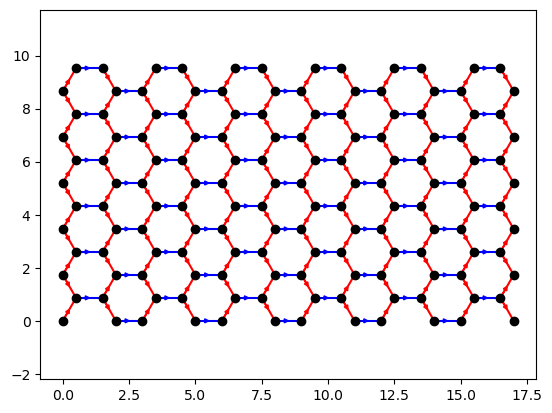

In [8]:
fig, ax = PlotGraph(S, Δ);
#ax.view_init(5, 10)

## Thermal Conductivity

## Thermal Bath Method


In [9]:
@everywhere include(dir * "/functions/simulationFunctions/DemonHeatBath.jl")

In [10]:
L = [15, 5]
PBC = [false, true]

num_histories = 1
therm_runtime = 300
runtime = 1500
t_therm = 200
t_autocorr = 1
N_blocks = -1

W = 5
Tc = 0.1
Th = 10.0

T, κ, C, Diff, TStd, κStd, CStd, DiffStd = BathSimulation(L, PBC, Basis, W, Tc, Th, num_histories, therm_runtime, runtime, t_therm, t_autocorr, N_blocks);

idx = W+1:size(T, 2)-W+1;

In [11]:
# FUDGE FACTOR - WHYYY MISSING FACTOR 1/2????
κ[1,:] ./= 2;
κ[2,:] ./= 2;

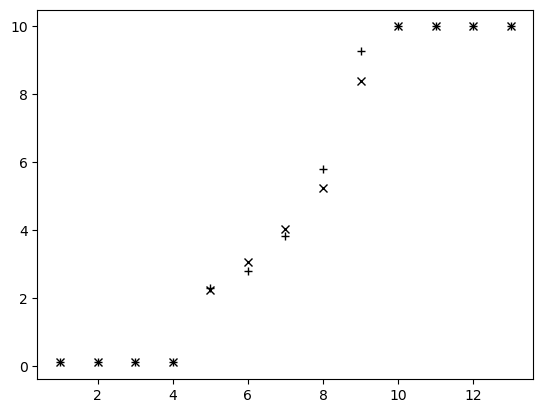

In [12]:
figure()
plotWithError(T[1,:], 1:size(T, 2), :black, "+", TStd[1,:])
plotWithError(T[2,:], 1:size(T, 2), :black, "x", TStd[2,:])
savefig("figs/Demon_Bath_Temperatures.png")

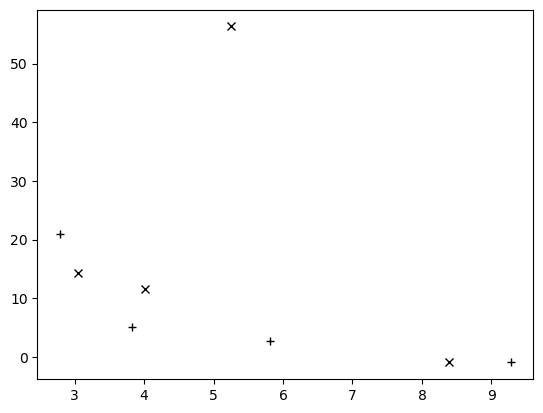

In [13]:
figure()
plotWithError(C[1,idx], T[1,idx], :black, "+")#, CStd[1,idx,i], TStd[1,idx,i])
plotWithError(C[2,idx], T[2,idx], :black, "x")#, CStd[2,idx,i], TStd[2,idx,i])
savefig("figs/Demon_Bath_Capacity.png")

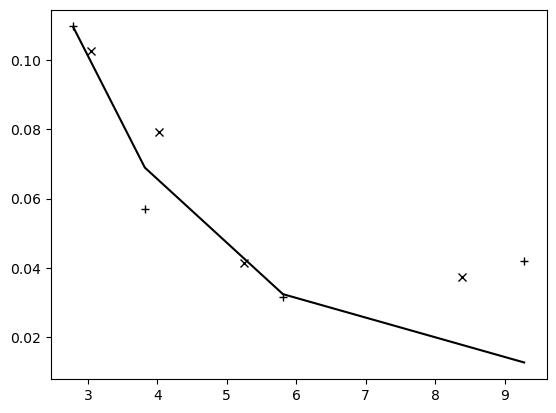

In [14]:
figure()
plot(T[1,idx], Kfun(T[1,idx], 0), color=:black)
    
plotWithError(κ[1,idx], T[1,idx], :black, "+")#, κStd[1,idx,i], TStd[1,idx,i])
plotWithError(κ[2,idx], T[2,idx], :black, "x")#, κStd[2,idx,i], TStd[2,idx,i])

savefig("figs/Demon_Bath_Conductivity.png")

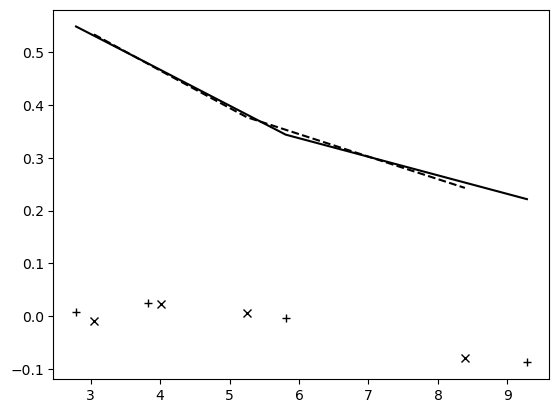

(PyObject <matplotlib.lines.Line2D object at 0x00000000D56A1C90>, (), (PyObject <matplotlib.collections.LineCollection object at 0x00000000D56A1DE0>, PyObject <matplotlib.collections.LineCollection object at 0x00000000D56A2200>))

In [15]:
figure()
plot(T[1,idx], Dfun(T[1,idx], 0), color=:black)
plot(T[2,idx], Dfun(T[2,idx], 0), color=:black, "--")
plotWithError(Diff[1,idx], T[1,idx], :black, "+")#, DiffStd[1,idx,i], TStd[1,idx,i])
plotWithError(Diff[2,idx], T[2,idx], :black, "x")#, DiffStd[2,idx,i], TStd[2,idx,i])

In [16]:
savefig("figs/Demon_Bath_Diffusivity.png")

In [17]:
save("data/DemonBath.jld", "Size", L, 
                           "num_histories", num_histories, 
                           "therm_runtime", therm_runtime, 
                           "runtime", runtime, 
                           "t_therm", t_therm, 
                           "basis", Basis, 
                           "lambda", λ, 
                           "xi", ξ, 
                           "EnergyQuantisation", δE, 
                           "Dself", Dself, 
                           "twoFlip", twoFlip, 
                           "idx", idx, 
                           "Temperature", T, 
                           "TemperatureStd", TStd, 
                           "Conductivity", κ, 
                           "ConductivityStd", κStd, 
                           "Capacity", C, 
                           "CapacityStd", CStd, 
                           "Diffusivity", Diff, 
                           "DiffusivityStd", DiffStd)

In [18]:
T       = Nothing
κ       = Nothing
C       = Nothing
Diff    = Nothing
TStd    = Nothing
κStd    = Nothing
CStd    = Nothing
DiffStd = Nothing

Nothing

In [19]:
t1 = now()
print("\n", canonicalize(t1 - t0))


38 seconds, 425 milliseconds

## Green-Kubo Method

### Demon Dynamics

In [20]:
@everywhere include(dir * "/functions/simulationFunctions/DemonKubo.jl")

In [21]:
#global testing = []

# PARAMETERS
L = [5, 5]
PBC = [true, true]

# find minimal representable temperature (just done for 𝒽=0 for now - MAYBE MODIFY TO PICK MAX OVER DIFF FIELDS??
#Nmin = (T,h) -> (λ == 0 ? 2/(4*exp(-4/T)/3+h*exp(-2*h/T)) : 2/(exp(-2/T)+2*h*exp(-2*h/T))) # minimal lattice size on which T=Tmin is possible - see https://www.desmos.com/calculator/ll1ljvjmcg for details
Tmin = 0.1 # find_zero((T) -> prod(L)-Nmin(T,0), 0.3)
Tmax = 10.0
NumT = 50
T = collect(range(Tmin, Tmax, length=NumT)) # the +0.1 is a fudge factor to fix our approximations earlier... (exact value doesn't matter b/c just adds ~a single demon)

𝒽 = [0.0]

num_histories = 1
runtime = 1000
t_therm = 100
t_cutoff = 100
t_autocorr = 100
N_blocks = -1

# EVALUATION
Tobs, κ, C, Diff, TobsStd, κStd, CStd, DiffStd = DKuboSimulation(L, PBC, Basis, num_histories, runtime, t_therm, t_autocorr, N_blocks, t_cutoff, T, 𝒽);

In [22]:
now()

2023-10-20T16:02:37.998

In [23]:
colors = jetmap(length(𝒽))

5-element Vector{Tuple{Float64, Float64, Float64}}:
 (0.0, 0.0, 0.498)
 (0.0, 0.498, 1.0)
 (0.498, 1.0, 0.498)
 (1.0, 0.498, 0.0)
 (0.498, 0.0, 0.0)

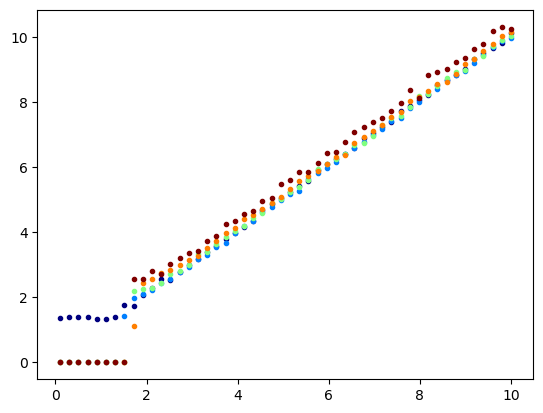

In [24]:
figure()
for i in eachindex(𝒽)
    plotWithError(Tobs[:,i], T, colors[i], ".", "" , TobsStd[:,i])
end
savefig("figs/Demon_Kubo_Temperature.png")
# Just to check that out temperature estimates aren't too far off

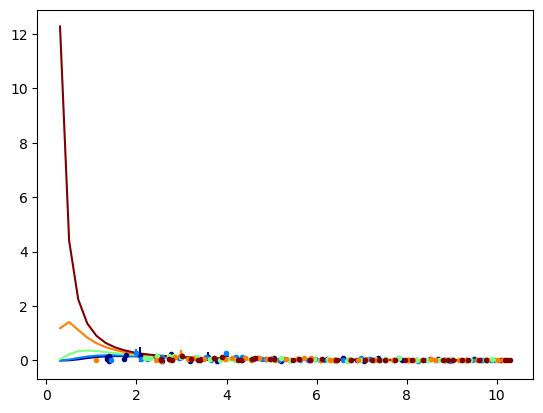

In [25]:
figure()
for i in eachindex(𝒽)
    plot(T[2:end], Kfun(T[2:end], 𝒽[i]), color=colors[i])
    plotWithError(κ[:,i], Tobs[:,i], colors[i], ".", "" , κStd[:,i], TobsStd[:,i])
end
savefig("figs/Demon_Kubo_Conductivity.png")

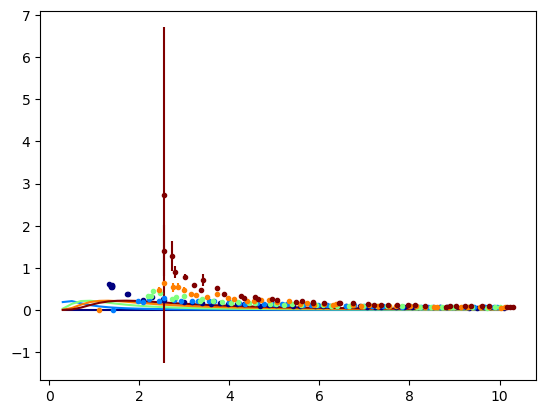

In [26]:
figure()
for i in eachindex(𝒽)
    plot(T[2:end], Cfun(T[2:end], 𝒽[i]), color=colors[i])
    
    plotWithError(C[:,i], Tobs[:,i], colors[i], ".", "" , CStd[:,i], TobsStd[:,i])
end
savefig("figs/Demon_Kubo_Capacity.png")

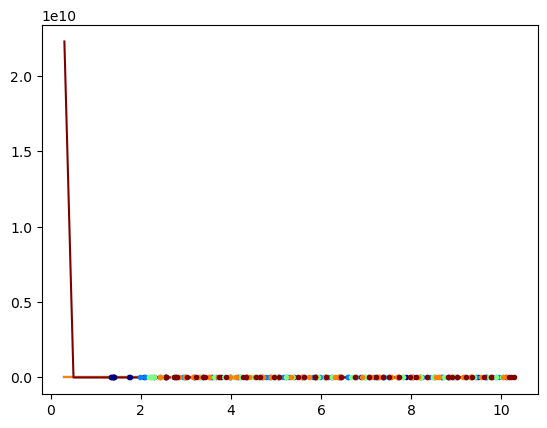

In [27]:
figure()
for i in eachindex(𝒽)
    plot(T[2:end], Dfun(T[2:end], 𝒽[i]), color=colors[i])
    
    plotWithError(Diff[:,i], Tobs[:,i], colors[i], ".", "" , DiffStd[:,i], TobsStd[:,i])
end
savefig("figs/Demon_Kubo_Diff.png")

In [28]:
save("data/DemonKubo.jld", "Size", L, 
                           "Fields", 𝒽, 
                           "num_histories", num_histories, 
                           "therm_runtime", therm_runtime, 
                           "runtime", runtime, 
                           "t_therm", t_therm, 
                           "t_cutoff", t_cutoff, 
                           "basis", Basis,
                           "lambda", λ, 
                           "xi", ξ, 
                           "EnergyQuantisation", δE,
                           "Dself", Dself, 
                           "twoFlip", twoFlip, 
                           "TargetTemperature", T, 
                           "ObservedTemperature", Tobs, 
                           "ObservedTemperatureStd", TobsStd, 
                           "Conductivity", κ, 
                           "ConductivityStd", κStd, 
                           "Capacity", C, 
                           "CapacityStd", CStd, 
                           "Diffusivity", Diff, 
                           "DiffusivityStd", DiffStd)

In [29]:
Tobs    = Nothing
κ       = Nothing
C       = Nothing
Diff    = Nothing
TobsStd = Nothing
κStd    = Nothing
CStd    = Nothing
DiffStd = Nothing

Nothing

In [30]:
t2 = now()
print(canonicalize(t2 - t1))

57 seconds, 967 milliseconds

### Microcanonical Dynamics

In [23]:
@everywhere include(dir * "/functions/simulationFunctions/MicroKubo.jl")

In [ ]:
# PARAMETERS
L = [24, 24]
PBC = [true, true]

Tmin = 0.01
Tmax = 10.0
NumT = 50

#Tmax *= (λ == 0 ? 1.0 : 0.5)
T = collect(range(Tmin, Tmax, length=NumT))

𝒽 = [0.0] # range(0, 2, length=5) # 

num_histories = 5
therm_runtime = 1000
runtime = 1000
t_therm = 100
t_autocorr = 100
N_blocks = -1
t_cutoff = 100

allComponents = false


# EVALUATION
κ, C, Diff, κStd, CStd, DiffStd = MKuboSimulation(L, PBC, Basis, num_histories, runtime, therm_runtime, t_therm, t_autocorr, N_blocks, t_cutoff, T, 𝒽, allComponents);

In [ ]:
now()

In [ ]:
colors = jetmap(length(𝒽));

In [ ]:
dim = allComponents ? length(L) : 1
for i in 1:dim
    for j in 1:dim
        δij = (i==j) ? 1 : 0
        
        figure()
        for n in eachindex(𝒽)
            plot(T[2:end], δij .* Kfun(T[2:end], 𝒽[n]), color=colors[n])

            plotWithError(κ[i,j,:,n], T, colors[n], ".", "" , κStd[i,j,:,n])
        end
        
        savefig("figs/Micro_Kubo_Conductivity_" * string(i) * string(j) * ".png")
    end
end

In [ ]:
figure()
for n in eachindex(𝒽)
    #plot(T[2:end], Cfun(T[2:end], 𝒽[n]), color=colors[n])
    plot(T, HeatCapacity(T, 𝒽[n], z), "--", color=colors[n])
    
    plotWithError(C[:,n], T, colors[n], ".", "" , CStd[:,n])
end
savefig("figs/Micro_Kubo_Capacity.png")

In [ ]:
figure()
for i in 1:dim
    for j in 1:dim
        δij = (i==j) ? 1 : 0
        
        figure()
        for n in eachindex(𝒽)
            plot(T[2:end], δij .* Dfun(T[2:end], 𝒽[n]), color=colors[n])
            
            plotWithError(Diff[i,j,:,n], T, colors[n], ".", "" , DiffStd[i,j,:,n])
        end
        
        savefig("figs/Micro_Kubo_Diff_" * string(i) * string(j) * ".png")
    end
end

In [14]:
save("data/MicroKubo.jld", "Size", L,
                           "Fields", 𝒽,
                           "num_histories", num_histories,
                           "therm_runtime", therm_runtime,
                           "runtime", runtime,
                           "t_therm", t_therm,
                           "t_cutoff", t_cutoff,
                           "basis", Basis,
                           "lambda", λ,
                           "xi", ξ,
                           "EnergyQuantisation", δE,
                           "Dself", Dself,
                           "twoFlip", twoFlip,
                           "allComponents", allComponents,
                           "Temperature", T,
                           "Conductivity", κ,
                           "ConductivityStd", κStd,
                           "Capacity", C,
                           "CapacityStd", CStd,
                           "Diffusivity", Diff,
                           "DiffusivityStd", DiffStd)

In [ ]:
κ       = Nothing
C       = Nothing
Diff    = Nothing
κStd    = Nothing
CStd    = Nothing
DiffStd = Nothing

In [7]:
t3 = now()
print("\n", canonicalize(t3 - t2))

LoadError: UndefVarError: t2 not defined

### Diffusive Motion

In [7]:
@everywhere include(dir * "/functions/simulationFunctions/MicroKubo.jl")
@everywhere include(dir * "/functions/simulationFunctions/MicroDiffusion.jl")

In [ ]:
L = [25, 25]
PBC = [true, true]

therm_runtime = 500 # floor(Int64,(maximum(L)./2)^2/2/length(L)/Dself) # 1000
runtime = 500
tau = 2:200
num_histories = 10
𝒽 = [0.0]; #collect(range(0, 2, length=5))

T = []; # collect(range(0.01, 1.0, length=20));
ℓ = collect(range(1, 15, step=1)); # [1];

Basis = SquareBasis()

x, δ, Mag, Perc, P, Nv = DiffSim(L, PBC, Basis, therm_runtime, runtime, ℓ, T, 𝒽);

In [ ]:
figure()
for h in 1:length(x[1][1])
    for p in 1:size(x[1][1][h], 2)
        plot(x[1][1][h][1,p,:], x[1][1][h][2,p,:])
    end
end
savefig("figs/trajectories.pdf")

In [ ]:
D, α, C, γ, MSD, VACF = DiffAnalysis(x, δ, P, runtime, ℓ, T, 𝒽);

colors = jetmap(length(𝒽));
colorsℓ = jetmap(length(ℓ));

In [ ]:
Mag = mean(Mag, dims=3)

figure()
for i in eachindex(𝒽)
    if length(T) > 0
        scatter(T, Mag[:,i], color=colors[i])
        plot(T, Magnetisation(T, 𝒽[i], z), color=colors[i])
    elseif length(ℓ) > 0
        scatter(ℓ, Mag[:,i], color=colors[i])
    end
end
savefig("figs/Magnetisation.png")

In [ ]:
Perc = mean(Perc, dims=3)

figure()
for i in eachindex(𝒽)
    if length(T) > 0
        scatter(T, Perc[:,i], color=colors[i])
    elseif length(ℓ) > 0
        scatter(ℓ, Perc[:,i], color=colors[i])
    end
end

savefig("figs/Percolation.png")

In [ ]:
figure()
for t in 1:size(MSD, 2)
    for i in 1:size(MSD, 3)
        if MSD[tau,t,i] != [NaN for _ in 1:size(MSD, 1)]
            #loglog(MSD[:,t,i], color=colors[i])
            plot(MSD[tau,t,i], color=colorsℓ[t])
        end
    end
end
plot(2 .* length(L) .* D[1] .* tau .^ α[1], color=:black, "--")
savefig("figs/MSD.png")

In [ ]:
# step direction autocorrelation
figure()
for t in 1:size(VACF, 2)
    for i in 1:size(VACF, 3)
        if VACF[tau,t,i] != [NaN for _ in 1:size(VACF, 1)]
            #loglog(abs.(VACF[:,t,i]), color=colors[i])
            plot(VACF[tau,t,i], color=colorsℓ[t])
        end
    end
end
sgn = sign(VACF[findmax(abs.(VACF[:,1,1]))[2],1,1])
plot(-sgn .* length(L) .* abs(C[1]) .* tau .^ γ[1], color=:black, "--")
savefig("figs/VACF.png")

In [ ]:
# estimate based on assuming the number of particles is <ϵ_i>/2λ/2 in single vertex approxn
figure() # density of quasiparticles
p = mean(P, dims=3) ./ Nv
if length(T) > 0
    for i in eachindex(𝒽)
        scatter(T, p[:,i], color=colors[i])
        plot(T, ExcitationDensity(T, 𝒽[i], z), color=colors[i])
    end
elseif length(ℓ) > 0
    pExp = 2 .* ℓ ./ Nv
    for i in eachindex(𝒽)
        scatter(ℓ, p[:,i], color=colorsℓ)
    end
    plot(ℓ, pExp, color=:black, "--")
end
savefig("figs/Quasiparticle Number.png")

In [ ]:
figure() # msd diffusion coefficient
if length(T) > 0
    for i in eachindex(𝒽)
        plot(T[2:end], 2 .* length(L) .* Dfun(T[2:end], 𝒽[i]), color=colors[i])
        
        plotWithError(D[1,:,i], T, colors[i], ".", "" , D[2,:,i])
    end
elseif length(ℓ) > 0
    plot(2 .* ℓ, Dself .* (1 .- 2 .* ℓ ./ Nv), color=:black)
    for i in eachindex(𝒽)
        plotWithError(D[1,:,i], 2 .* ℓ, colors[i], ".", "" , D[2,:,i])
    end
end
savefig("figs/MSD_Coefficient.png")

In [ ]:
figure() # msd diffusion exponent
if length(T) > 1
    for i in eachindex(𝒽)
        plotWithError(α[1,:,i], T, colors[i], ".", "" , α[2,:,i])
    end
elseif length(ℓ) > 0
    for i in eachindex(𝒽)
        plotWithError(α[1,:,i], 2*ℓ, colors[i], ".", "" , α[2,:,i])
    end
end
savefig("figs/MSD_Exponent.png")

In [ ]:
# MSD EXPONENT NUMBER TWO!
numExcitations = (temp) -> temp==0 ? 0 : Nv * (ExcitationDensity([temp], 0.0, z))[1]
T = zeros(length(ℓ))

for n in eachindex(ℓ)
    fn = (t) -> numExcitations(t) - 2*ℓ[n]
    T[n] = find_zero(fn, (0, 10))
end

print(T)

figure()

plotWithError(α[1,:,1], T, :black, ".", "" , α[2,:,1]);

In [ ]:
figure() # vacf diffusion coefficient
if length(T) > 0
    for i in eachindex(𝒽)
        plot(T[2:end], length(L) .* Dfun(T[2:end], 𝒽[i]), color=colors[i])
        
        plotWithError(C[1,:,i], T, colors[i], ".", "" , D[2,:,i])
    end
elseif length(ℓ) > 0
    plot(2 .* ℓ, Dself .* (1 .- 2 .* ℓ ./ Nv), color=:black)
    for i in eachindex(𝒽)
        plotWithError(C[1,:,i], 2 .* ℓ, colors[i], ".", "" , D[2,:,i])
    end
end
savefig("figs/VACF_Coefficient.png")

In [ ]:
figure() # vacf diffusion exponent
if length(T) > 1
    for i in eachindex(𝒽)
        plotWithError(γ[1,:,i], T, colors[i], ".", "" , α[2,:,i])
    end
elseif length(ℓ) > 0
    for i in eachindex(𝒽)
        plotWithError(γ[1,:,i], ℓ, colors[i], ".", "" , α[2,:,i])
    end
end
savefig("figs/VACF_Exponent.png")

In [ ]:
print("D = ", D[1,1,1], " ± ", D[2,1,1], "\n\n")
print("α = ", α[1,1,1], " ± ", α[2,1,1], "\n\n")
print("C = ", C[1,1,1], " ± ", C[2,1,1], "\n\n")
print("γ = ", γ[1,1,1], " ± ", γ[2,1,1], "\n\n")

In [ ]:
print(α[1,1,1]+1, " ± ", α[2,1,1], "\n\n")
print(2*γ[1,1,1]+4, " ± ", 2*γ[2,1,1], "\n\n")

save("data/MicroDiff.jld", "Size", L,
                           "Fields", 𝒽,
                           "num_histories", num_histories,
                           "therm_runtime", therm_runtime,
                           "runtime", runtime,
                           "tau", tau,
                           "basis", Basis,
                           "lambda", λ,
                           "xi", ξ,
                           "EnergyQuantisation", δE,
                           "Dself", Dself,
                           "twoFlip", twoFlip,
                           "Temperature", T,
                           "NumFlippedEdges", ℓ,
                           "MSD", MSD,
                           "VACF", VACF,
                           "D", D,
                           "alpha", α,
                           "C", C,
                           "gamma", γ)

In [ ]:
t4 = now()
print("\n", canonicalize(t4 - t3))

### Diffusion Subgraphs

In [ ]:
@everywhere include(dir * "/functions/simulationFunctions/MicroDiffusion.jl")
@everywhere include(dir * "/functions/simulationFunctions/MicroKubo.jl")

In [ ]:
Basis = SquareBasis()
L = [64, 64]
PBC = [true, true]

therm_runtime = 4000
T_therm = 1
𝒽 = 0.0
randomInit = false
numToFlip = 1

Δ, scale = LatticeGrid(L, PBC, Basis)

S = MicroDiffnSetup(Δ, 1);l
MicroDiffn(S, Δ, therm_runtime, 𝒽, false);

#S, _ = MicroKuboSetup(Δ, therm_runtime, T_therm, 𝒽, randomInit);

In [71]:
# find all the excitations
js = []
Qjs = []
for i in eachindex(Δ.cells[1])
    Ai = Star(S, Δ, i)
    Qi = -Boundary(S, Δ, i)

    if (isSpinIce ? (abs(Qi) == 3 || abs(Qi) == 2) : Ai == -1)
        push!(js, i)
        push!(Qjs, Qi)
    end
end
print(size(js))

(2,)

#### Charge Subgraphs

#### Arrow Subgraphs

In [72]:
using DataStructures

function BFS(S, Δ, u) # u = starting vertex
    
    # define whether to follow spins or go against them
    Qu = -Boundary(S, Δ, u) # charge of starting vertex
    isReachable = (Svw) -> (Svw == sign(Qu))
    
    seenV = zeros(Bool, length(Δ.cells[1]))
    seenE = zeros(Bool, length(Δ.cells[2]))
    toExplore = Queue{Int}()
    
    enqueue!(toExplore, u)
    seenV[u] = true
    
    while length(toExplore)> 0
        v = dequeue!(toExplore)
        
        for (e, k) in zip(Δ.cells[1][v].∂ᵀ, Δ.cells[1][v].ηᵀ) # loop over connected edges
            
            w = Δ.cells[2][e].∂[findfirst(Δ.cells[2][e].∂ .!= v)] # connected vertex
            
            Svw = -GetCpt(S, k*e, true) # spin from v to w
            
            if isReachable(Svw)
                seenE[e] = true
                
                if !seenV[w]
                    enqueue!(toExplore, w)
                    seenV[w] = true
                end
            end
        end 
    end

    return [seenV, seenE, []]
end

BFS (generic function with 1 method)

In [73]:
function DFS(S, Δ, u) # u = starting vertex
    
    # define whether to follow spins or go against them
    Qu = -Boundary(S, Δ, u) # charge of starting vertex
    isReachable = (Svw) -> (Svw == sign(Qu))
    
    seenV = zeros(Bool, length(Δ.cells[1]))
    seenE = zeros(Bool, length(Δ.cells[2]))
    toExplore = Stack{Int}()
    
    push!(toExplore, u)
    seenV[u] = true
    
    while length(toExplore)> 0
        v = pop!(toExplore)
        
        for (e, k) in zip(Δ.cells[1][v].∂ᵀ, Δ.cells[1][v].ηᵀ) # loop over connected edges
            
            w = Δ.cells[2][e].∂[findfirst(Δ.cells[2][e].∂ .!= v)] # connected vertex
            
            Svw = -GetCpt(S, k*e, true) # spin from v to w
            
            if isReachable(Svw)
                seenE[e] = true
                
                if !seenV[w]
                    push!(toExplore, w)
                    seenV[w] = true
                end
            end
        end 
    end

    return [seenV, seenE, []]
end

DFS (generic function with 1 method)

#### Shortest Path Scaling

In [74]:
function BFS_path(S, Δ, s, ts, isReachable)
    
    # define whether to follow spins or go against them
    Q = -Boundary(S, Δ, s) # charge of the (starting) vertex that will be hopping around

    seen = zeros(Bool, length(Δ.cells[1]))
    comeFrom = zeros(Int, length(Δ.cells[1]))
    toExplore = Queue{Int}()
    
    enqueue!(toExplore, s)
    seen[s] = true
    
    while length(toExplore)> 0
        v = dequeue!(toExplore)
        
        for (e, k) in zip(Δ.cells[1][v].∂ᵀ, Δ.cells[1][v].ηᵀ) # loop over connected edges
            
            w = Δ.cells[2][e].∂[findfirst(Δ.cells[2][e].∂ .!= v)] # connected vertex
            Qw = -Boundary(S, Δ, w) # charge of the target vertex
            
            Svw = -GetCpt(S, k*e, true) # spin from v to w
            
            if !seen[w] && isReachable(Svw, Q, Qw)
                enqueue!(toExplore, w)
                seen[w] = true
                comeFrom[w] = v
            end
        end 
    end
    
    ds = zeros(Int, length(ts))
    
    for n in eachindex(ts)
        if s==ts[n]
            ds[n] = 0
        elseif comeFrom[ts[n]] == 0
            ds[n] = -1 # NaN
        else
            path = [ts[n]]
            while comeFrom[path[1]] != s
                prepend!(path, comeFrom[path[1]])
            end
            prepend!(path, s)
            
            ds[n] = length(path) - 1
        end
    end

    return ds
end

BFS_path (generic function with 1 method)

Now we want to compute the shortest graph distance as a function of the Euclidean distance (correcting for PBCS)

In [75]:
isReachable_SI = (Svw, Qv, Qw) -> Svw == sign(Qv - Qw)
isReachable_boring = (Svw, Qv, Qw) -> true

#192 (generic function with 1 method)

In [76]:
s = js[1]
ts = 1:length(Δ.cells[1])


ds = BFS_path(S, Δ, s, ts, isReachable_SI);
d0s = BFS_path(S, Δ, s, ts, isReachable_boring);

In [77]:
data = [[d0s[n] ds[n]] for n in eachindex(ds)];
dict = countmap(data);

dmax = max(maximum(d0s), maximum(ds));

N = zeros(Int, dmax+1, dmax+1);

for entry in dict
    v = entry[1] .+ 1
    
    if v[2] > 0 # ignore NaN values where ds[n]=-1
        N[v[1], v[2]] += entry[2]
    end
end

In [78]:
d0s_unique = unique(d0s)
ds_avg = zeros(length(d0s_unique))
len = zeros(length(d0s_unique))

for n in eachindex(d0s_unique)
    for m in eachindex(d0s)
        if d0s[m]==d0s_unique[n]
            len[n] += 1
            ds_avg[n] += ds[m]
        end
    end
end

ds_avg ./= len;

I = sortperm(d0s_unique)
d0s_unique = d0s_unique[I];
ds_avg = ds_avg[I];

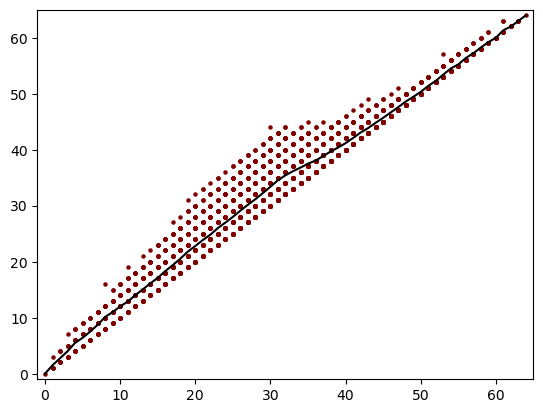

In [79]:
upLim = max(maximum(d0s), maximum(ds))+1
lowLim = -1;
#plot([lowLim, upLim], [lowLim, upLim], c=:black);
scatter(d0s, ds, s=5, c=:maroon);

plot(d0s_unique, ds_avg, c=:black)

# axis("equal");
xlim([lowLim, upLim]);
ylim([lowLim, upLim]);

# -1 values are unreachable so not included in the average or imshow

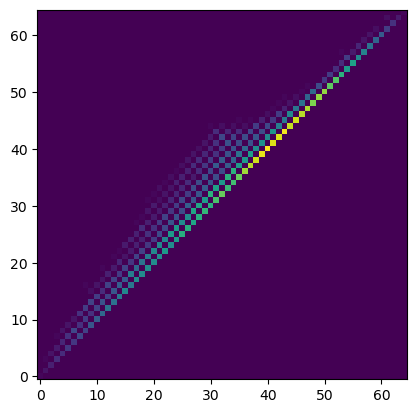

In [80]:
imshow(N', origin="lower");

In [81]:
print("\nTOTAL RUNTIME = ", canonicalize(t5 - t0))

LoadError: UndefVarError: t5 not defined

In [82]:
close("all") 